In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
%matplotlib inline
plt.ioff()
import pandas as pd

from functools import reduce

# For python >= 3.8, do: from math import product
def product(iterable):
  return reduce(lambda x, y : x * y, iterable, 1)

def lmap(predicate, iterable):
  return list(map(predicate, iterable))

In [2]:
from numpy.random import random

In [3]:
df = pd.read_csv('US_births_2000-2014_SSA.csv')

# Check there are the right number of days
assert len(df) - 365*15 - 4 == 0

df.head()

,year,month,date_of_month,day_of_week,births
0,2000,1,1,6,9083
1,2000,1,2,7,8006
2,2000,1,3,1,11363
3,2000,1,4,2,13032
4,2000,1,5,3,12558


# 1. Visualization

In [4]:
mean_births = df.births.sum() / len(df)

rel_freq = (
  df.groupby(['month', 'date_of_month'])
    .births
    .mean()
) / mean_births

In [5]:
# Day closest to rel_freq == 1
print(f'Most average day : {(rel_freq - 1).abs().idxmin()}')

# Maximum frequency
print(f'Most frequent day: {(rel_freq).idxmax()}')

Most average day : (12, 16)
Most frequent day: (9, 12)


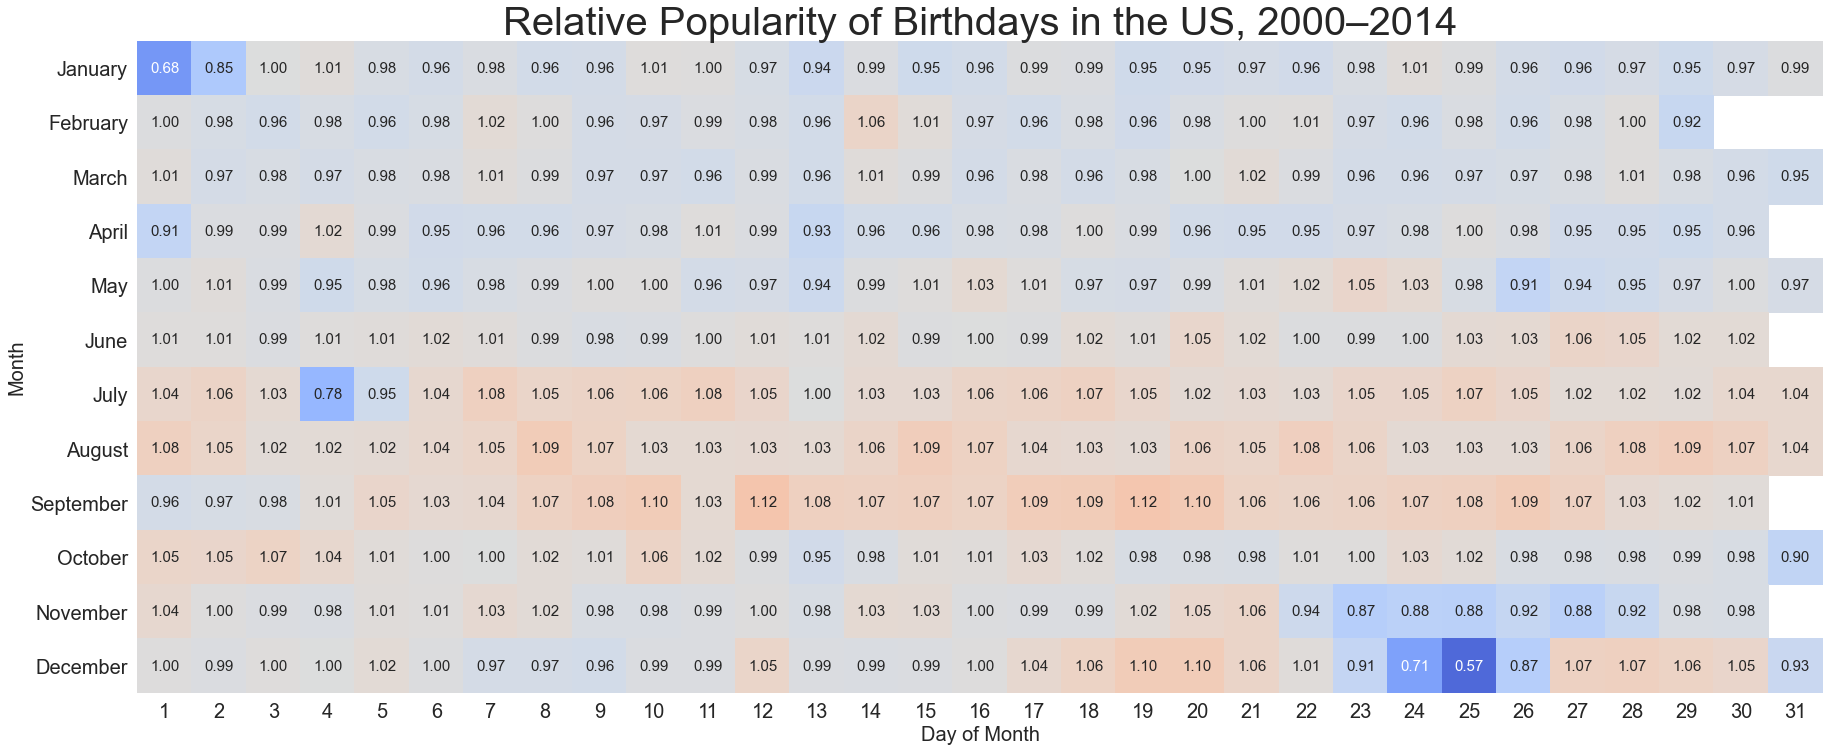

In [6]:
fig, ax = plt.subplots(figsize = (31, 12))
sns.heatmap(rel_freq.unstack(-1),
            ax = ax, 
            center = 1, 
            vmin = 0.5,
            vmax = 1.5,
            annot = True,
            fmt = '.2f',
            square = True,
            cmap = 'coolwarm',
            cbar = False,
            annot_kws = {'fontdict' : {'fontsize' : 15}}
           )

font_dict = {'fontsize' : 20}
ax.set_facecolor('white')
ax.set_xlabel('Day of Month', font_dict)
ax.set_ylabel('Month', font_dict)
ax.set_yticklabels([
  'January',
  'February',
  'March',
  'April',
  'May',
  'June',
  'July',
  'August',
  'September',
  'October',
  'November',
  'December'
], font_dict, rotation = 0)
ax.set_title('Relative Popularity of Birthdays in the US, 2000–2014', fontdict = {'fontsize' : 40})#{'fontsize' : 40})
plt.xticks(fontsize = 20)
plt.yticks(rotation = 0)
fig.savefig('outputs/chart.png', transparent = True)
plt.show()

# 2. Exact Computation in the Uniform Case

In [7]:
def uniform_birthday_problem(n):
  return 1 - product([(365-k)/365 for k in range(n)])

In [8]:
n_range = list(range(100))
uniform_p = pd.DataFrame({
  'n'       : n_range,
  'p'       : lmap(uniform_birthday_problem, n_range),
  '0.5'     : [0.5 for _ in n_range],
})

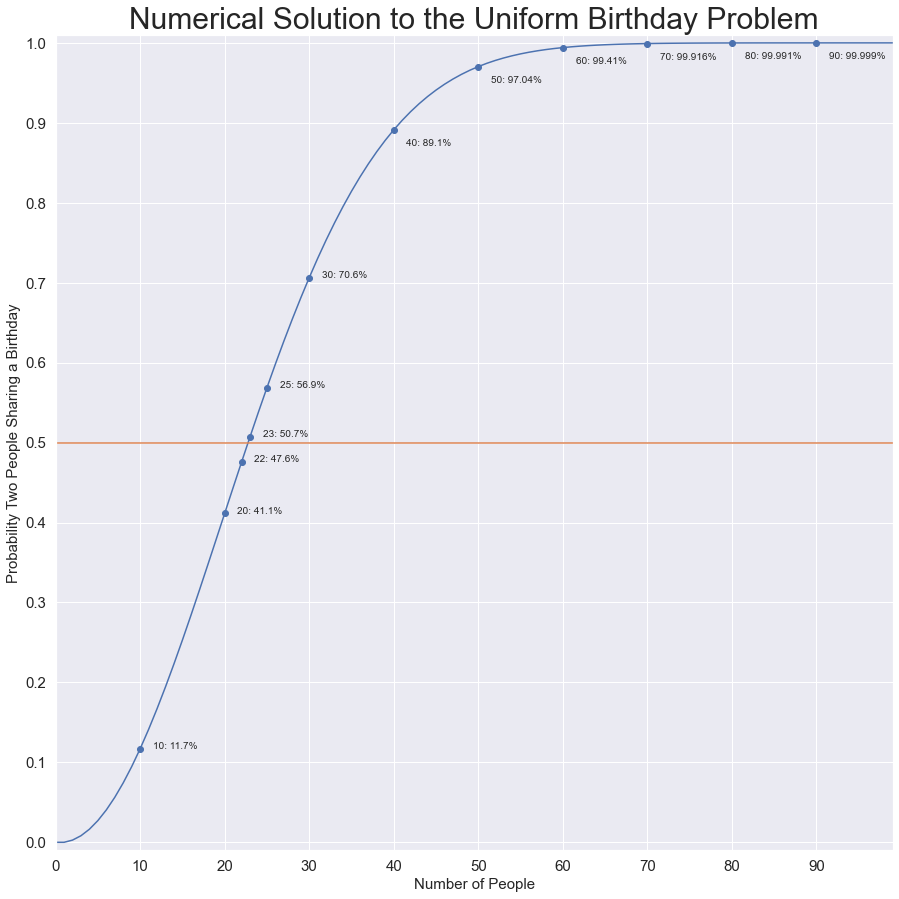

In [9]:
fig, ax = plt.subplots(figsize = (15, 15))
sns.lineplot(
  data = uniform_p.melt(id_vars = 'n'),
  x    = 'n',
  y    = 'value',
  hue  = 'variable',
  ax   = ax
)

# Annotations. Offsets are hand-coded for the figure
for n in [10, 20, 22, 23, 25, 30, 40, 50, 60, 70, 80, 90]:
  p = uniform_p.p[n]
  ax.scatter(n, p, color = sns.color_palette()[0])
  if n >= 40:
    xy = (n + 1.5, p - 0.02)
  elif n == 22:
    xy = (n + 1.5, p)
  else:
    xy = (n + 1.5, p)
  
  if 1-p >= 0.1:
    text = f'{n}: {p:.1%}'
  elif 1-p >= 0.001:
    text = f'{n}: {p:.2%}'
  else:
    text = f'{n}: {p:.3%}'

  ax.annotate(text, xy)
  
font_dict = {'fontsize' : 15}
ax.get_legend().remove()
ax.set_title('Numerical Solution to the Uniform Birthday Problem', fontdict = {'fontsize' : 30})
ax.set_yticks([x/10 for x in range(11)])
ax.set_xticks([x * 10 for x in range(10)])
ax.set_ylim([-0.01,1.01])
ax.set_xlim([0, 99])
ax.set_xlabel('Number of People', font_dict)
ax.set_ylabel('Probability Two People Sharing a Birthday', font_dict)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

fig.savefig('outputs/uniform_numerical.png', bbox_inches = 'tight')
plt.show()

# 3. Monte Carlo Simulation of the Empirical Case

In [10]:
def simulate_birthday_problem(n, num_samples, dist):
  '''Monte Carlo estimation of the birthday problem
  
  Parameters
  ----------
  
  n           : Int. Number of people
  num_samples : Int. how many samples to take
  dist        : Pandas Series. A discrete probability
                distribution with values equal to the 
                probability of a birthday on any given day.
                Must sum to one.
                
  Returns
  -------
  
  shared_birthday: a boolean numpy array of shape (num_samples,)
                   True: two people shared a birthday in that sample
                   False: two people did not.
  
  '''
  
  
  # Uniform numbers between 0 and 1
  rvs = random(size = (n, num_samples))
  
  birthday_counts = []
  
  # For each date, count how many people share the birthday in each sample
  last_cutoff = 0
  for births in dist.cumsum():
    birthday_on_day = (rvs >= last_cutoff) & (rvs < births)
    num_birthdays   = birthday_on_day.sum(axis = 0)
    birthday_counts.append(num_birthdays)
    last_cutoff = births
  
  # Then aggregate across each sample
  birthday_counts = np.array(birthday_counts)
  shared_birthday = birthday_counts >= 2
  shared_birthday = shared_birthday.sum(axis = 0) >= 1
  return shared_birthday

In [11]:
def run_simulation(n_range, num_samples, dist):
  '''Get data to estimate the birthday curve P(n)
  
  P(n) is the function giving the probability
  that some two people in a room of n people have
  the same birthday, assuming their birthdays are
  distributed according to dist, a discrete probability
  distribution.
  
  Parameters
  ----------
  
  n_range     : Int. The function P(n) is computed for
                values 0, 1, 2, ..., n_range-1

  num_samples : Int. Number of samples to use to estimate
                each value of P(n)
                
  dist        : Pandas Series. A discrete probability
                distribution with values equal to the 
                probability of a birthday on any given day.
                Must sum to one.
                
  Returns
  -------
  
  simulation_data : a numpy array of shape (n_range, num_samples)
                    giving the results of each sample for each value of n
  
  '''

  # For reproducability
  np.random.seed(42)
  
  simulation_data = {n : simulate_birthday_problem(n, num_samples, dist) for n in range(n_range)}
  
  simulation_data = (
  pd.DataFrame(simulation_data)
    .melt(var_name = 'n', value_name = 'p')
  )

  simulation_data['p'] = simulation_data.p.astype(int)
  
  return simulation_data

In [12]:
# The empirical birthday distribution from our data
#  Differs from data used in part 1 because Feb 29
#  is treated differently
p = (
  df.groupby(['month', 'date_of_month'])
    .births
    .sum()
)

p /= p.sum()

## 3.1 Test Cases
 - This should reproduce the chart above in the case of the uniform distribution

It does. Confidence intervals shown are 99% confidence intervals. Based on 10000 samples for each n

 - This should produce 100% for n > 1 in the case of all the probability mass being on a single day

In [13]:
%%time
uniform_dist = p.copy().drop((2, 29))
uniform_dist.iloc[:] = 1/365
simulation_data = run_simulation(100, 10000, uniform_dist)

CPU times: user 54.5 s, sys: 3.05 s, total: 57.5 s
Wall time: 1min


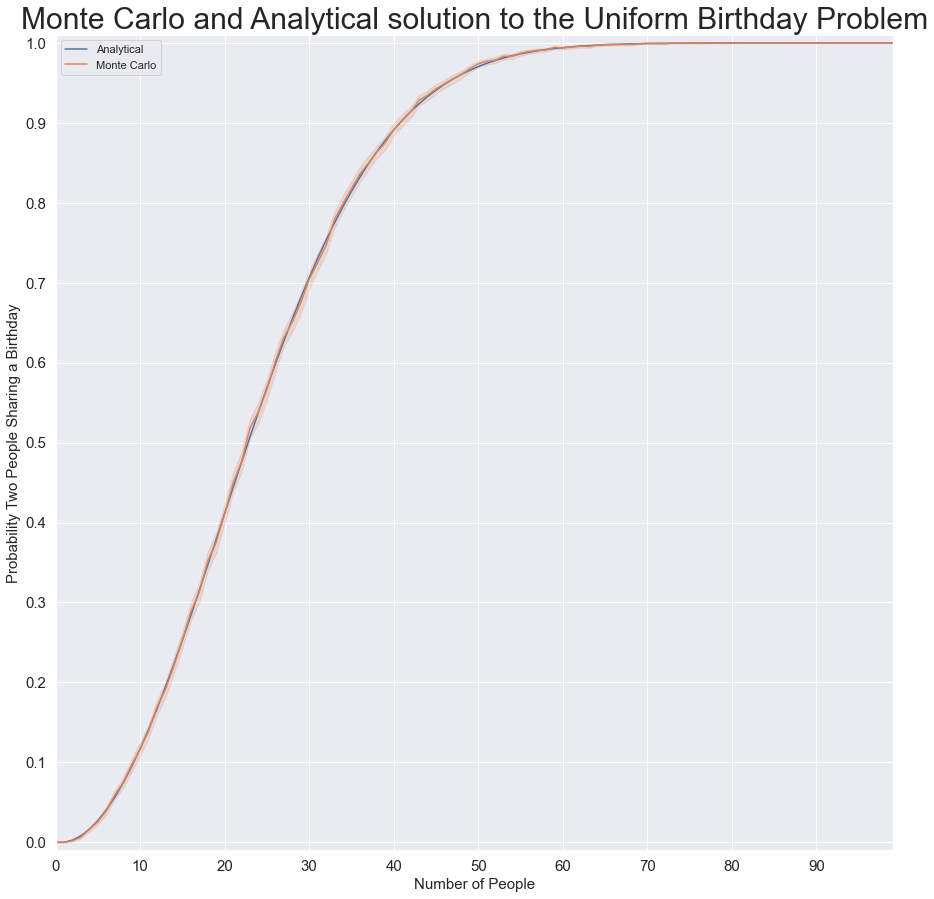

In [14]:
fig, ax = plt.subplots(figsize = (15, 15))
sns.lineplot(
  data = uniform_p,
  x    = 'n',
  y    = 'p',
  ax   = ax
)

sns.lineplot(
  data = simulation_data,
  x = 'n', 
  y = 'p',
  ax = ax,
  ci = 99
)

font_dict = {'fontsize' : 15}
ax.set_title('Monte Carlo and Analytical solution to the Uniform Birthday Problem', fontdict = {'fontsize' : 30})
ax.set_yticks([x/10 for x in range(11)])
ax.set_xticks([x * 10 for x in range(10)])
ax.set_ylim([-0.01,1.01])
ax.set_xlim([0, 99])
ax.set_xlabel('Number of People', font_dict)
ax.set_ylabel('Probability Two People Sharing a Birthday', font_dict)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.legend(['Analytical', 'Monte Carlo'])

fig.savefig('outputs/uniform_mc.png')
plt.show()

In [ ]:
non_random = p.copy()
non_random.iloc[:] = 0
non_random[(1,1)] = 1
simulation_data = run_simulation(10, 1000, non_random)

simulation_data.groupby('n').mean()

## 3.2 Simulation
Up the sample size to 100,000 for the main figure

In [16]:
%%time
simulation_data = run_simulation(100, 100000, p)
main_data = simulation_data

CPU times: user 9min 53s, sys: 55.3 s, total: 10min 48s
Wall time: 11min 49s


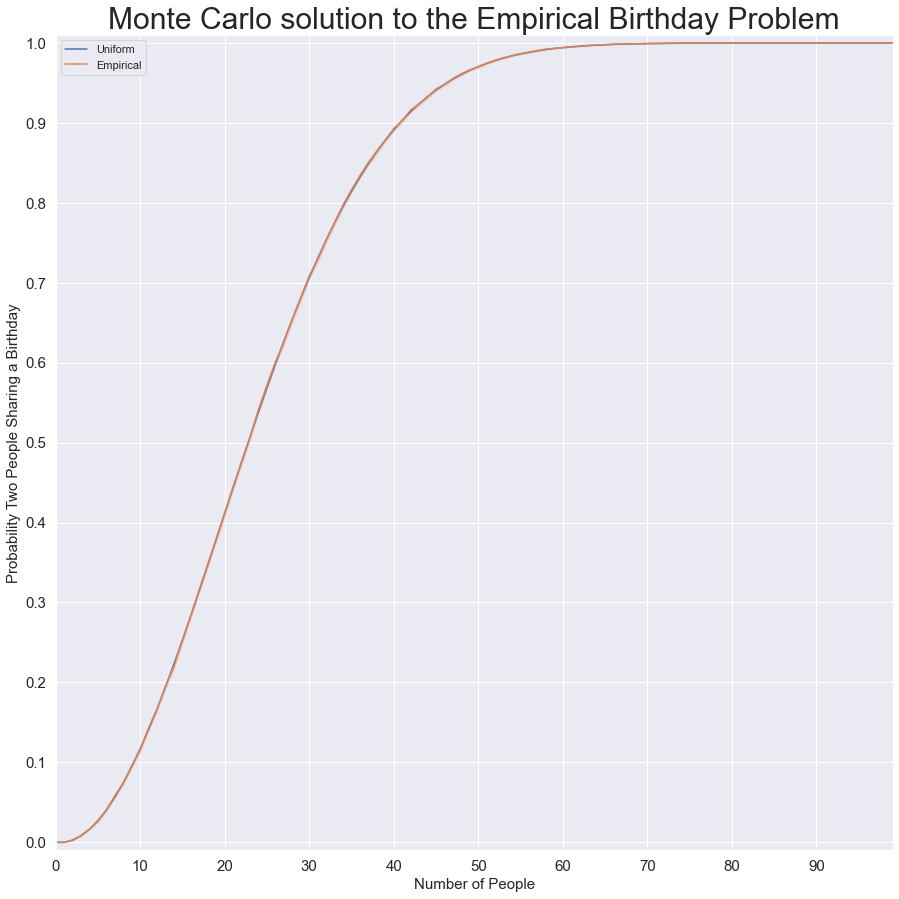

CPU times: user 1min 57s, sys: 3.93 s, total: 2min 1s
Wall time: 2min 12s
Compiler : 220 ms


In [17]:
%%time
fig, ax = plt.subplots(figsize = (15,15))
sns.lineplot(
  data = uniform_p,
  x    = 'n',
  y    = 'p',
  ax   = ax
)

sns.lineplot(
  data = main_data,
  x = 'n', 
  y = 'p',
  ax = ax,
  ci = 99
)

font_dict = {'fontsize' : 15}
ax.set_title('Monte Carlo solution to the Empirical Birthday Problem', fontdict = {'fontsize' : 30})
ax.set_yticks([x/10 for x in range(11)])
ax.set_xticks([x * 10 for x in range(10)])
ax.set_ylim([-0.01,1.01])
ax.set_xlim([0, 99])
ax.set_xlabel('Number of People', font_dict)
ax.set_ylabel('Probability Two People Sharing a Birthday', font_dict)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.legend(['Uniform', 'Empirical'])

fig.savefig('outputs/empirical_mc.png')
display(fig)
plt.close('all')

In [18]:
comparison = simulation_data.merge(
  uniform_p.drop('0.5', axis = 'columns'), 
  how = 'left',
  on = 'n', 
  suffixes = ('_empirical', '_uniform')
)

comparison['delta'] = comparison.p_empirical - comparison.p_uniform

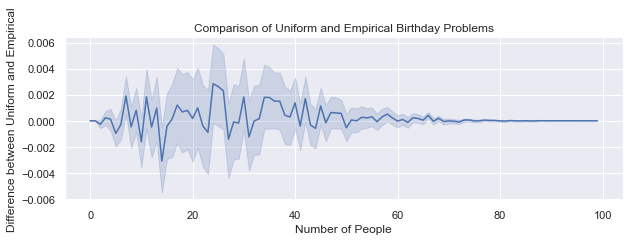

CPU times: user 1min 45s, sys: 3.36 s, total: 1min 48s
Wall time: 1min 56s


In [19]:
%%time
fig, ax = plt.subplots(figsize = (10, 3))
sns.lineplot(
  data = comparison.reset_index(),
  x = 'n',
  y = 'delta',
  ci = 95
)
ax.set_xlabel('Number of People')
ax.set_ylabel('Difference between Uniform and Empirical')
ax.set_title('Comparison of Uniform and Empirical Birthday Problems')
fig.savefig('outputs/uniform_empirical_delta.png', bbox_inches = 'tight')

plt.show()

In [20]:
%%time
np.random.seed(42)

val_23 = simulate_birthday_problem(23, 5000000, p)
val_23 = val_23.astype(int)

from math import sqrt
mu = val_23.mean()
se = sqrt(val_23.var() / len(val_23))
print(f'Empirical n=23: {mu:.3%} ±{se:.3%}')
print(f'Uniform   n=23: {uniform_p.p[23]:.3%}')

Empirical n=23: 50.786% ±0.022%
Uniform   n=23: 50.730%
CPU times: user 2min 41s, sys: 49.4 s, total: 3min 31s
Wall time: 4min 10s


## 3.3 Skewed Simulation

To check that a change in the birthday problem would appear if the non-uniformity were more pronounced, we make this distribution even more skewed (in a non-technical sense)

In [21]:
skewed = p.copy()**10
skewed /= skewed.sum()

In [22]:
%%time
skewed_data = run_simulation(100, 10000, skewed)

CPU times: user 54.5 s, sys: 2.95 s, total: 57.4 s
Wall time: 1min


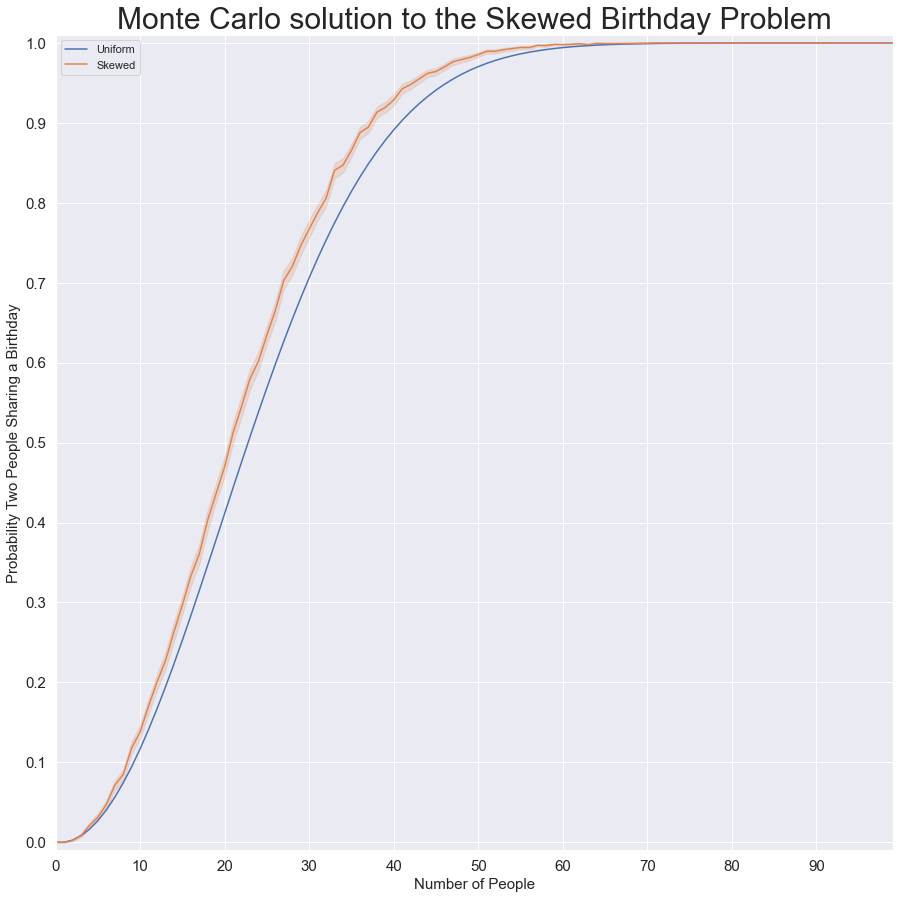

In [23]:
fig, ax = plt.subplots(figsize = (15,15))
sns.lineplot(
  data = uniform_p,
  x    = 'n',
  y    = 'p',
  ax   = ax
)

sns.lineplot(
  data = skewed_data,
  x = 'n', 
  y = 'p',
  ax = ax,
  ci = 99
)

font_dict = {'fontsize' : 15}
ax.set_title('Monte Carlo solution to the Skewed Birthday Problem', fontdict = {'fontsize' : 30})
ax.set_yticks([x/10 for x in range(11)])
ax.set_xticks([x * 10 for x in range(10)])
ax.set_ylim([-0.01,1.01])
ax.set_xlim([0, 99])
ax.set_xlabel('Number of People', font_dict)
ax.set_ylabel('Probability Two People Sharing a Birthday', font_dict)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.legend(['Uniform', 'Skewed'])

fig.savefig('outputs/skewed_mc.png')
plt.show()

# 4. The Birthday Problem on an Annual Basis